In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import cv2
from torchvision.ops import nms  

In [2]:
# NMS function for ensembling predictions
def nms_ensemble(predictions, iou_threshold=0.15):
    boxes = []
    scores = []
    
    for pred in predictions:
        boxes.append(pred.boxes.xyxy.cpu().numpy())
        scores.append(pred.boxes.conf.cpu().numpy())
        print(pred.boxes.id)

    boxes = np.concatenate(boxes)
    scores = np.concatenate(scores)

    # Perform Non-Maximum Suppression
    indices = nms(torch.tensor(boxes), torch.tensor(scores), iou_threshold)
    
    # Filter the boxes and scores using NMS indices
    nms_boxes = boxes[indices]
    nms_scores = scores[indices]
    
    return nms_boxes, nms_scores

# Function to draw bounding boxes
def draw_boxes(image, boxes, scores, color, label):
    for box, conf in zip(boxes, scores):
        x1, y1, x2, y2 = box
        # Draw the rectangle for each box
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        # Put the label and confidence on top of the rectangle
        cv2.putText(image, f"{label} {conf:.2f}", (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


In [3]:
yolo_models = ["yolov8s_custom.pt", "yolov8m_custom.pt"]
models = [YOLO(x) for x in yolo_models]


image 1/1 d:\azure\PRS-PM-2024-01-13-AIS06PT-GRP8-TheNightsWatch-StreetOwl\SystemCode\notebooks\BaselineCrowdModel\sample.jpg: 384x640 22 Humans, 133.0ms
Speed: 3.0ms preprocess, 133.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 d:\azure\PRS-PM-2024-01-13-AIS06PT-GRP8-TheNightsWatch-StreetOwl\SystemCode\notebooks\BaselineCrowdModel\sample.jpg: 384x640 32 Humans, 137.1ms
Speed: 2.6ms preprocess, 137.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
None
None
Ensembled model 24 detected.


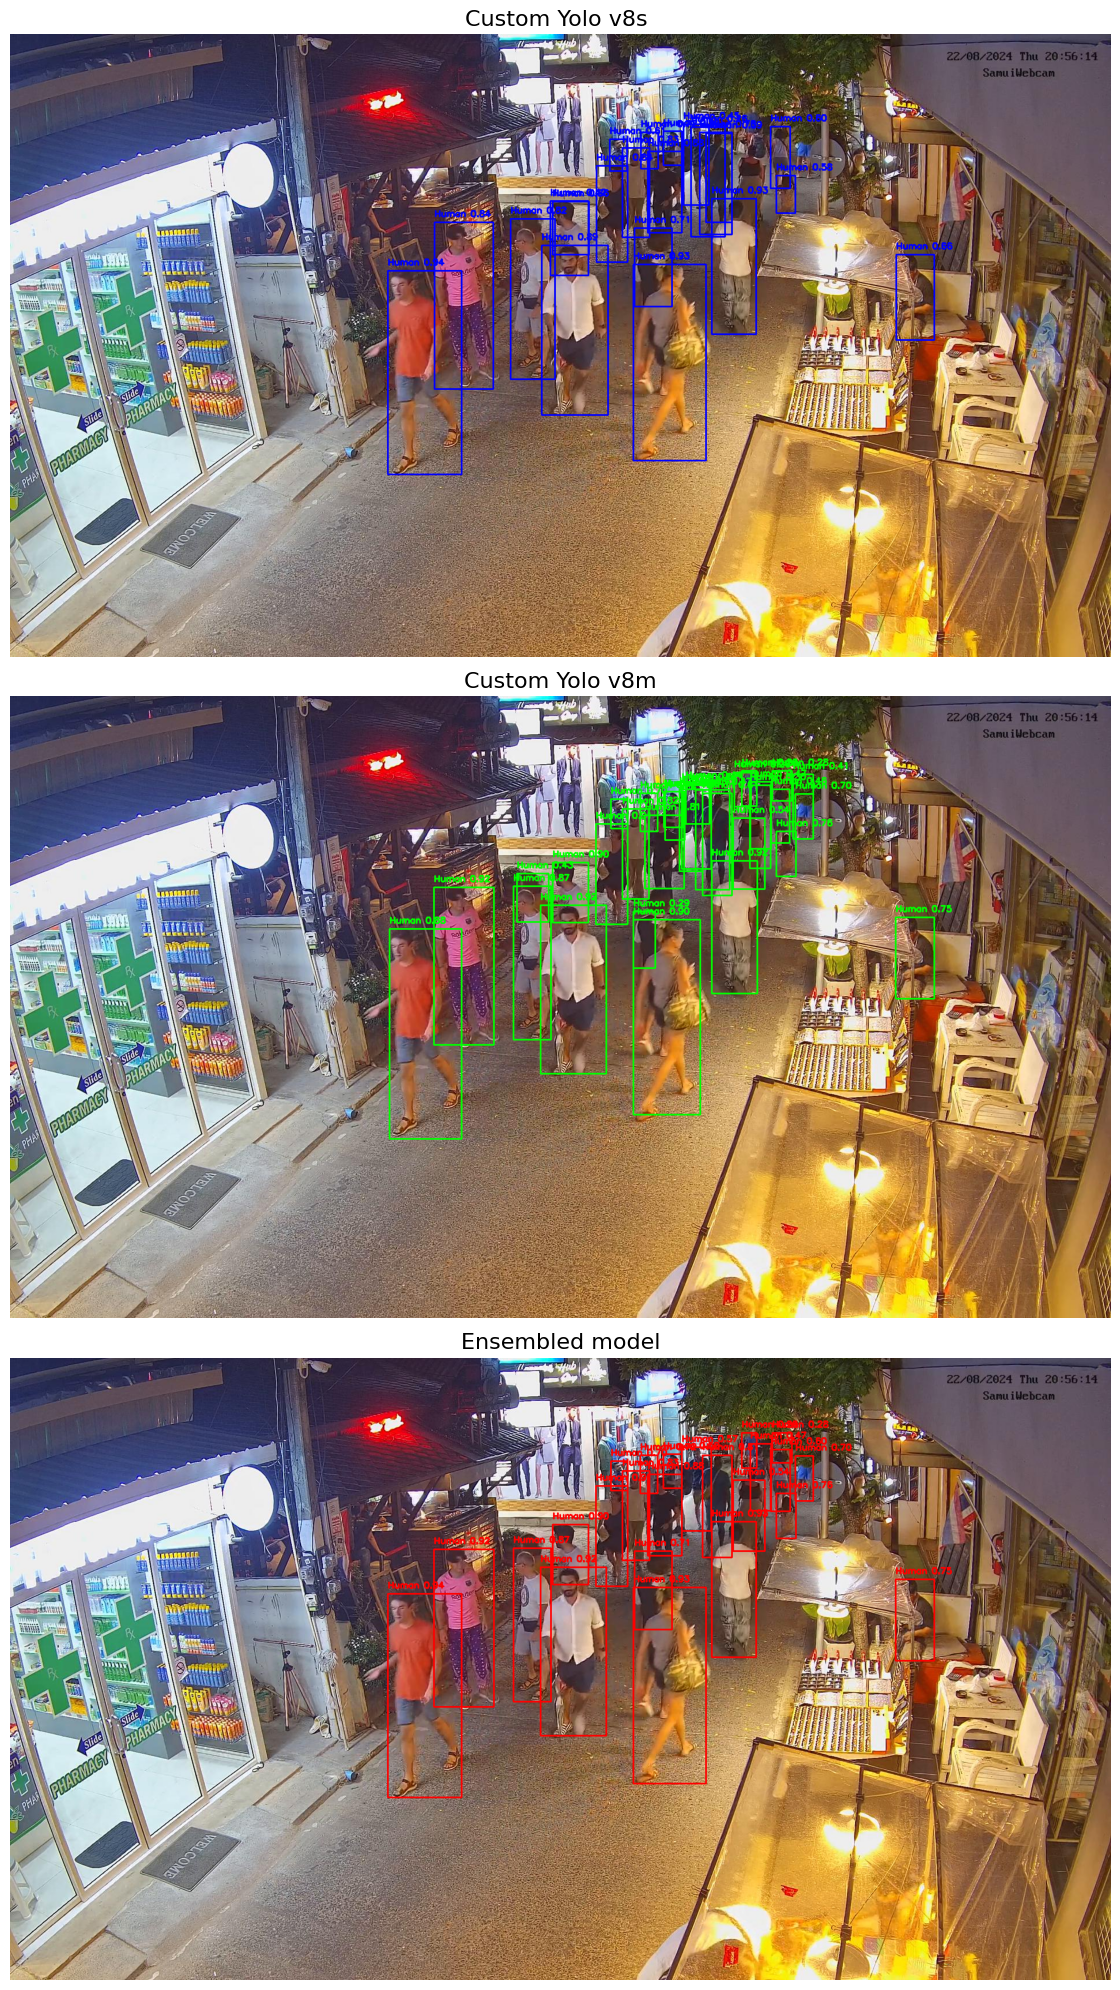

In [8]:

# Load an image
image_path = "sample.jpg"
original_image = cv2.imread(image_path)
image_model1 = original_image.copy()
image_model2 = original_image.copy()
image_ensemble = original_image.copy()

# Get individual model predictions
pred_model1 = models[0](image_path)[0]  
pred_model2 = models[1](image_path)[0]  

# Ensemble predictions using NMS
nms_boxes, nms_scores = nms_ensemble([pred_model1, pred_model2])

draw_boxes(image_model1, pred_model1.boxes.xyxy.cpu().numpy(), pred_model1.boxes.conf.cpu().numpy(), (255, 0, 0), "Human")
draw_boxes(image_model2, pred_model2.boxes.xyxy.cpu().numpy(), pred_model2.boxes.conf.cpu().numpy(), (0, 255, 0), "Human")
draw_boxes(image_ensemble, nms_boxes, nms_scores, (0, 0, 255), "Human")
print(f"Ensembled model {len(nms_boxes)} detected.")

fig, axs = plt.subplots(3, 1, figsize=(15, 20))  # 3 rows, 1 column, and increased figure size

# display all predictions
axs[0].imshow(cv2.cvtColor(image_model1, cv2.COLOR_BGR2RGB))
axs[0].set_title('Custom Yolo v8s ', fontsize=16)

axs[1].imshow(cv2.cvtColor(image_model2, cv2.COLOR_BGR2RGB))
axs[1].set_title('Custom Yolo v8m', fontsize=16)

axs[2].imshow(cv2.cvtColor(image_ensemble, cv2.COLOR_BGR2RGB))
axs[2].set_title('Ensembled model', fontsize=16)

for ax in axs:
    ax.axis('off')

plt.tight_layout()  
plt.show()